In [1]:
import math
import random
import numpy as np
import numpy.ma as ma

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import namedtuple, deque

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from nim_env import NimEnv, OptimalPlayer
import pandas as pd
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
#State and next state vectors (datatype tensor) of 9 bits
#Action index of the made action
#Reward -1,0,1

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(in_features=9,out_features=128)
        self.layer2 = nn.Linear(in_features=128,out_features=128)
        self.head = nn.Linear(in_features=128,out_features=21)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        #x size 64x9
        x = F.relu(self.layer1(x)) #64x128
        x = F.relu(self.layer2(x)) #64x128
        return self.head(x) #64x21

In [4]:
def heaps_to_bits(heaps):
    #Return vector of length 9
    #Heap numbers from 1
    #If [0,0,0] -> None
    if heaps == [0,0,0]:
        return None
    else:
        return [int(bin(heaps[0])[2:].zfill(3)[-3]), int(bin(heaps[0])[2:].zfill(3)[-2]), int(bin(heaps[0])[2:].zfill(3)[-1]),
               int(bin(heaps[1])[2:].zfill(3)[-3]), int(bin(heaps[1])[2:].zfill(3)[-2]), int(bin(heaps[1])[2:].zfill(3)[-1]),
               int(bin(heaps[2])[2:].zfill(3)[-3]), int(bin(heaps[2])[2:].zfill(3)[-2]), int(bin(heaps[2])[2:].zfill(3)[-1])]

In [74]:
#Copy pasted so that we remember to create same methods
class NimDQNlearningAgent:
    #Q learning agent for Nim with epsilon-greedy policy
    def __init__(self, alpha=0.1, gamma=0.99, epsilon=0.1, player=0, buffer_size=10000, batch_size=64, target_network=None, policy_network=None, ReplayBuffer=None, useBuffer=True):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.player = player #  0 or 1
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.useBuffer = useBuffer
        
        #Initialize replay buffer
        if self.useBuffer:
            if ReplayBuffer is not None:
                self.buffer = ReplayBuffer
            else:
                self.buffer = ReplayMemory(self.buffer_size)
        else:
            self.buffer = None
        
        #Initialize networks
        if policy_network is not None:
            self.policy_network = policy_network
        else:
            self.policy_network = DQN()
        if target_network is not None:
            self.target_network = target_network
        else:
            self.target_network = DQN()
            self.target_network.load_state_dict(self.policy_network.state_dict())
            
        self.optimizer = torch.optim.Adam(self.policy_network.parameters(), lr=0.0005)
    
    def copy(self):
        return NimDQNlearningAgent(alpha=self.alpha, gamma=self.gamma, epsilon=self.epsilon, player=self.player, buffer_size=self.buffer_size, batch_size=self.batch_size, target_network=self.target_network, policy_network=self.policy_network, ReplayBuffer=self.buffer, useBuffer=self.useBuffer)
    
    def randomMove(self, heaps):
        # choose a random move from the available heaps
        heaps_avail = [i for i in range(len(heaps)) if heaps[i] > 0]
        chosen_heap = random.choice(heaps_avail)
        n_obj = random.choice(range(1, heaps[chosen_heap] + 1))
        move = [chosen_heap + 1, n_obj]
        return move
    
    def act(self, heaps):
        # take a state, return the action with max Q-value
        if random.random() < self.epsilon:
            return self.randomMove(heaps)
        else:
            #Q values from policy network
            s = heaps_to_bits(heaps)
            Q = self.policy_network(torch.tensor(s).float())
            i_max = np.argmax(Q.detach().numpy())
            #Transform into heap number and number of sticks
            move = [i_max//7+1, i_max%7+1]
            return move
        
    def update(self, oldHeaps, move, newHeaps, reward):
        old_state = torch.tensor(heaps_to_bits(oldHeaps)).float()
        new_state = heaps_to_bits(newHeaps)
        if new_state is not None:
            new_state = torch.tensor(new_state).float()
        index_of_move = torch.tensor([(move[0]-1)*7 + move[1]-1]).float()
        reward = torch.tensor([reward]).float()
        
        if self.useBuffer:
            #Save to replay buffer
            self.buffer.push(old_state,index_of_move,new_state,reward)
            #Sample from replay if possible and update policy netwok
            if len(self.buffer) < self.batch_size:
                return None
            transitions = self.buffer.sample(self.batch_size)
        else:
            transitions = [Transition(old_state,index_of_move,new_state,reward)]
        
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
        #Check if there is no non final states
        if all(not x for x in non_final_mask):
            next_state_values = torch.zeros(self.batch_size)
        else:
            # Compute V(s_{t+1}) for all next states.
            non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
            non_final_next_states = non_final_next_states.view(int(non_final_next_states.size()[0]/9),9)
            next_state_values = torch.zeros(self.batch_size)
            next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(1)[0]
            
        state_batch = torch.cat(batch.state).view(self.batch_size,9)
        action_batch = torch.cat(batch.action).long()
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_network(state_batch).gather(1, action_batch.view(-1,1))

        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        #for param in policy_net.parameters():
            #param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        
        return loss.item()
        
    def update_target(self):
        self.target_network.load_state_dict(self.policy_network.state_dict())

In [104]:
def get_epsilonN(gameNumber, exploreGames, epsilonMin=0.1, epsilonMax=0.8):
    return max(epsilonMin, epsilonMax * (1 - gameNumber/exploreGames))

def playGames(env, player1, player2, decreaseExploration, exploGames=None, numGames=20000, update_cycle=500):
    reward_sum = 0
    loss_sum = 0.0
    loss_count = 0
    games_won = 0
    avg_rewards = []
    avg_train_loss = []
    M_opts = []
    M_rands = []
    for i in range(numGames):
        if decreaseExploration:
            player1.epsilon = get_epsilonN(i+1, exploGames)
        env.reset()
        lastActionState = None
        lastAction = None
        end_with_unavailable = False
        while not env.end:
            heaps, _, __ = env.observe()
            if env.current_player == player2.player:
                move = player2.act(heaps)
                newHeaps, end, winner = env.step(move)
            else:
                if (lastActionState is not None and lastAction is not None):
                    reward = env.reward(player=player1.player)
                    # update Q-values for the last state where the Q-learning agent was playing
                    loss = player1.update(lastActionState, lastAction, newHeaps, reward)
                    if loss is not None:
                        loss_sum += loss
                        loss_count += 1
                lastActionState = heaps.copy()
                move = player1.act(heaps)
                lastAction = move
                #Possibility to have unavailable action
                #If error, give reward -1 and end the game
                try:
                    newHeaps, end, winner = env.step(move)
                except AssertionError:
                    reward = -1
                    newHeaps = [0,0,0]
                    end = True
                    winner = player2.player
                    end_with_unavailable = True

            if end:
                if not end_with_unavailable:
                    reward = env.reward(player=player1.player)
                loss = player1.update(lastActionState, lastAction, newHeaps, reward)
                reward_sum += reward
                if loss is not None:
                        loss_sum += loss
                        loss_count += 1
                if reward > 0:
                    games_won += 1
                if ( (i+1) % 250 == 0):
                    #compute statistics
                    avg_rewards.append(reward_sum / 250)
                    avg_train_loss.append(loss_sum / loss_count)
                    reward_sum = 0
                    loss_sum = 0.0
                    loss_count = 0
                    M_opt = calc_M(player1, 0)
                    M_rand = calc_M(player1, 1)
                    M_opts.append(M_opt)
                    M_rands.append(M_rand)
                break
        # switch players
        player1.player = 1 - player1.player
        player2.player = 1 - player2.player
        
        #Every 500 game udate targer
        if (i+1) % update_cycle == 0:
            player1.update_target()
        
    
    print(f"Winrate: {games_won/numGames}")
    return avg_rewards, avg_train_loss, M_opts, M_rands

def playGamesAgainstItself(env, player1, decreaseExploration, exploGames=None, numGames=20000, update_cycle=500):
    M_opts = []
    M_rands = []
    for i in range(numGames):
        if decreaseExploration:
            player1.epsilon = get_epsilonN(i+1, exploGames)
        env.reset()
        lastActionState1 = None
        lastAction1 = None
        lastActionState2 = None
        lastAction2 = None
        while not env.end:
            heaps, _, __ = env.observe()
            if env.current_player == 0: # keep track of the correct state to update
                if (lastActionState1 is not None and lastAction1 is not None):
                    player1.update(lastActionState1, lastAction1, newHeaps, 0)
                lastActionState1 = heaps.copy()
                lastAction1 = player1.act(heaps)
                #Unavailable action possbile
                try:
                    newHeaps, end, winner = env.step(lastAction1)
                except AssertionError:
                    newHeaps = [0,0,0]
                    end = True
                    winner = 1
            else:
                if (lastActionState2 is not None and lastAction2 is not None):
                    player1.update(lastActionState2, lastAction2, newHeaps, 0)
                lastActionState2 = heaps.copy()
                lastAction2 = player1.act(heaps)
                #Unavailable action possbile
                try:
                    newHeaps, end, winner = env.step(lastAction2)
                except AssertionError:
                    newHeaps = [0,0,0]
                    end = True
                    winner = 0

            if end:
                #What happens whent the game ends on the first move?
                #Winner does not have last action -> Only loser learns something
                if winner == 0:
                    player1.update(lastActionState2, lastAction2, newHeaps, -1)
                    if lastActionState1 is not None:
                        player1.update(lastActionState1, lastAction1, newHeaps, 1)
                else:
                    player1.update(lastActionState1, lastAction1, newHeaps, -1)
                    if lastActionState2 is not None:
                        player1.update(lastActionState2, lastAction2, newHeaps, 1)
                if ( (i+1) % 250 == 0):
                    M_opt = calc_M(player1, 0)
                    M_rand = calc_M(player1, 1)
                    M_opts.append(M_opt)
                    M_rands.append(M_rand)
                break
                
        #Every 500 game udate targer
        if (i+1) % update_cycle == 0:
            player1.update_target()
    
    return M_opts, M_rands

def calc_M(player, epsilon, N=500):
    player_test = player.copy()
    player_test.player = 0
    player_test.epsilon = 0
    player_opt = OptimalPlayer(epsilon=epsilon, player=1)
    games_won = 0
    for i in range(N):
        env = NimEnv(seed=i)
        while not env.end:
            heaps, _, __ = env.observe()
            if env.current_player == player_opt.player:
                move = player_opt.act(heaps)
                newHeaps, end, winner = env.step(move)
            else:
                move = player_test.act(heaps)
                try:
                    newHeaps, end, winner = env.step(move)
                except AssertionError:
                    break
            if end:
                reward = env.reward(player=player_test.player)
                if reward > 0:
                    games_won += 1
                break

        player_opt.player = 1 - player_opt.player
        player_test.player = 1 - player_test.player
    
    return (2* games_won - N) / N

In [100]:
env = NimEnv(seed = 10)
random.seed(0)
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
mpl.rcParams.update(params)

# Learning from experts (Q11-15)

epsilon = 0.2, played 20 000 games against Opt(0.5)

In [84]:
# Question 11
player_Q = NimDQNlearningAgent(player=0, epsilon=0.2)
player_opt = OptimalPlayer(epsilon=0.5, player=1)
avg_rewards, avg_train_loss, M_opts, M_rands = playGames(env, player_Q, player_opt, decreaseExploration=False, numGames=20000)

Winrate: 0.5977


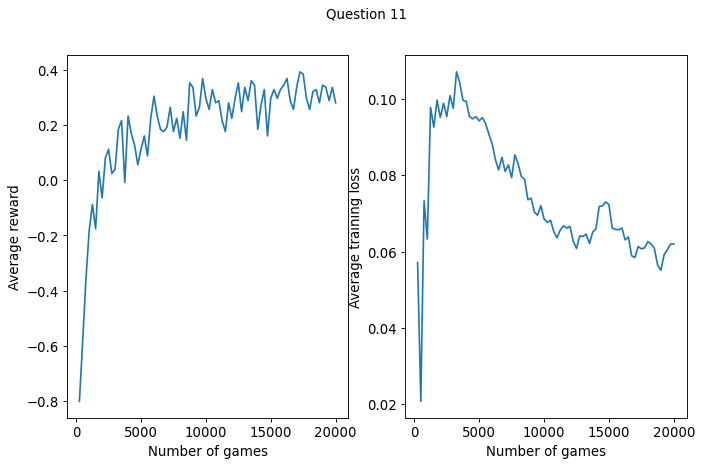

In [88]:
plt.figure(figsize=(10, 6), dpi=80)
plt.subplot(1, 2, 1)
ax1 = sns.lineplot(x=range(250, 20001, 250), y=avg_rewards)
ax1.set(ylabel="Average reward", xlabel="Number of games")
plt.subplot(1, 2, 2)
ax2 = sns.lineplot(x=range(250, 20001, 250), y=avg_train_loss)
ax2.set(ylabel="Average training loss", xlabel="Number of games")
plt.suptitle("Question 11")
plt.show()

In [90]:
#Question 12
player_Q = NimDQNlearningAgent(player=0, epsilon=0.2, batch_size=1, useBuffer=False)
player_opt = OptimalPlayer(epsilon=0.5, player=1)
avg_rewards, avg_train_loss, M_opts, M_rands = playGames(env, player_Q, player_opt, decreaseExploration=False, numGames=20000)

Winrate: 0.4747


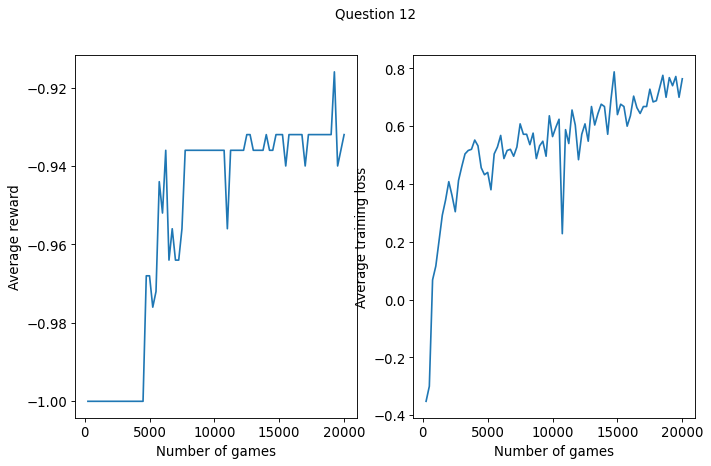

In [107]:
plt.figure(figsize=(10, 6), dpi=80)
plt.subplot(1, 2, 1)
ax1 = sns.lineplot(x=range(250, 20001, 250), y=avg_rewards)
ax1.set(ylabel="Average reward", xlabel="Number of games")
plt.subplot(1, 2, 2)
ax2 = sns.lineplot(x=range(250, 20001, 250), y=avg_train_loss)
ax2.set(ylabel="Average training loss", xlabel="Number of games")
plt.suptitle("Question 12")
plt.show()

In [95]:
#Question 13
player_opt = OptimalPlayer(epsilon=0.5, player=1)

M_optsDE = pd.DataFrame(index=range(250, 20001, 250)).rename_axis("Number of games")
M_optsDE = M_optsDE.rename_axis("n*", axis=1)

M_randsDE = pd.DataFrame(index=range(250, 20001, 250)).rename_axis("Number of games")
M_randsDE = M_randsDE.rename_axis("n*", axis=1)

player_DQN_DE = NimDQNlearningAgent(player=0)
avg_rewards, avg_train_loss, M_opts, M_rands = playGames(env, player_DQN_DE, player_opt, decreaseExploration=True, exploGames=1)
M_optsDE["1"] = M_opts
M_randsDE["1"] = M_rands

player_DQN_DE = NimDQNlearningAgent(player=0)
avg_rewards, avg_train_loss, M_opts, M_rands = playGames(env, player_DQN_DE, player_opt, decreaseExploration=True, exploGames=5000)
M_optsDE["5000"] = M_opts
M_randsDE["5000"] = M_rands

player_DQN_DE = NimDQNlearningAgent(player=0)
avg_rewards, avg_train_loss, M_opts, M_rands = playGames(env, player_DQN_DE, player_opt, decreaseExploration=True, exploGames=10000)
M_optsDE["10000"] = M_opts
M_randsDE["10000"] = M_rands

player_DQN_DE = NimDQNlearningAgent(player=0)
avg_rewards, avg_train_loss, M_opts, M_rands = playGames(env, player_DQN_DE, player_opt, decreaseExploration=True, exploGames=20000)
M_optsDE["20000"] = M_opts
M_randsDE["20000"] = M_rands

player_DQN_DE = NimDQNlearningAgent(player=0)
avg_rewards, avg_train_loss, M_opts, M_rands = playGames(env, player_DQN_DE, player_opt, decreaseExploration=True, exploGames=40000)
M_optsDE["40000"] = M_opts
M_randsDE["40000"] = M_rands

Winrate: 0.6352
Winrate: 0.6607
Winrate: 0.6058
Winrate: 0.52445
Winrate: 0.39895


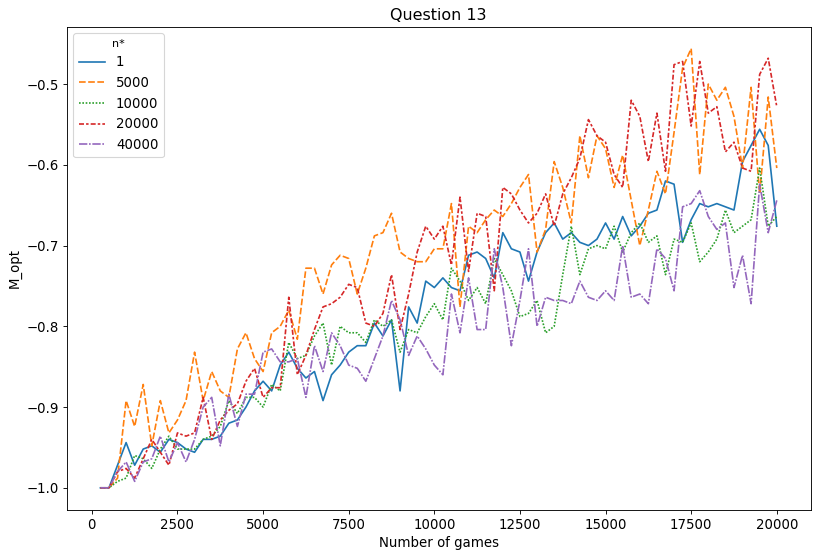

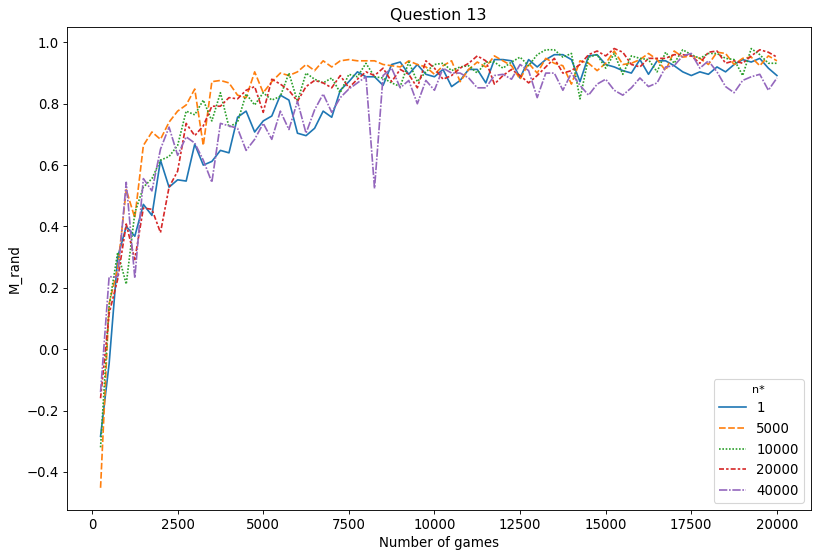

In [96]:
plt.figure(figsize=(12, 8), dpi=80)
ax = sns.lineplot(data=M_optsDE)
ax.set(ylabel="M_opt")
plt.title("Question 13")
plt.show()

plt.figure(figsize=(12, 8), dpi=80)
ax = sns.lineplot(data=M_randsDE)
ax.set(ylabel="M_rand")
plt.title("Question 13")
plt.show()

In [ ]:
#Question 14
n_star = 20000
M_optsDE2 = pd.DataFrame(index=range(250, 20001, 250)).rename_axis("Number of games")
M_optsDE2 = M_optsDE2.rename_axis("epsilon_opt", axis=1)

M_randsDE2 = pd.DataFrame(index=range(250, 20001, 250)).rename_axis("Number of games")
M_randsDE2 = M_randsDE2.rename_axis("epsilon_opt", axis=1)

player_opt = OptimalPlayer(epsilon=0, player=1)
player_DQN_DE0 = NimDQNlearningAgent(player=0)
avg_rewards, avg_train_loss, M_opts, M_rands = playGames(env, player_DQN_DE0, player_opt, decreaseExploration=True, exploGames=n_star)
M_optsDE2["0"] = M_opts
M_randsDE2["0"] = M_rands

player_opt.epsilon = 0.2
player_DQN_DE = NimDQNlearningAgent(player=0)
avg_rewards, avg_train_loss, M_opts, M_rands = playGames(env, player_DQN_DE, player_opt, decreaseExploration=True, exploGames=n_star)
M_optsDE2["0.2"] = M_opts
M_randsDE2["0.2"] = M_rands

player_opt.epsilon = 0.4
player_DQN_DE = NimDQNlearningAgent(player=0)
avg_rewards, avg_train_loss, M_opts, M_rands = playGames(env, player_DQN_DE, player_opt, decreaseExploration=True, exploGames=n_star)
M_optsDE2["0.4"] = M_opts
M_randsDE2["0.4"] = M_rands

player_opt.epsilon = 0.6
player_DQN_DE = NimDQNlearningAgent(player=0)
avg_rewards, avg_train_loss, M_opts, M_rands = playGames(env, player_DQN_DE, player_opt, decreaseExploration=True, exploGames=n_star)
M_optsDE2["0.6"] = M_opts
M_randsDE2["0.6"] = M_rands

player_opt.epsilon = 0.8
player_DQN_DE = NimDQNlearningAgent(player=0)
avg_rewards, avg_train_loss, M_opts, M_rands = playGames(env, player_DQN_DE, player_opt, decreaseExploration=True, exploGames=n_star)
M_optsDE2["0.8"] = M_opts
M_randsDE2["0.8"] = M_rands

player_opt.epsilon = 1
player_DQN_DE1 = NimDQNlearningAgent(player=0)
avg_rewards, avg_train_loss, M_opts, M_rands = playGames(env, player_DQN_DE1, player_opt, decreaseExploration=True, exploGames=n_star)
M_optsDE2["1"] = M_opts
M_randsDE2["1"] = M_rands

In [106]:
plt.figure(figsize=(12, 8), dpi=80)
ax = sns.lineplot(data=M_optsDE2)
ax.set(ylabel="M_opt")
plt.title("Question 14")
plt.show()

plt.figure(figsize=(12, 8), dpi=80)
ax = sns.lineplot(data=M_randsDE2)
ax.set(ylabel="M_rand")
plt.title("Question 14")
plt.show()

NameError: name 'M_optsDE2' is not defined

<Figure size 960x640 with 0 Axes>

Question 15: What are highest values for M_opt and M_rand?

# Learning by self practice (Q16-19)

In [105]:
#test
player_DQN = NimDQNlearningAgent(epsilon=0)
M_opts, M_rands = playGamesAgainstItself(env, player_DQN, decreaseExploration=False, numGames=20000)

In [ ]:
# Question 16
M_optsSP = pd.DataFrame(index=range(250, 20001, 250)).rename_axis("Number of games")
M_optsSP = M_optsSP.rename_axis("epsilon_Q", axis=1)

M_randsSP = pd.DataFrame(index=range(250, 20001, 250)).rename_axis("Number of games")
M_randsSP = M_randsSP.rename_axis("epsilon_Q", axis=1)

player_DQN = NimDQNlearningAgent(epsilon=0)
M_opts, M_rands = playGamesAgainstItself(env, player_DQN, decreaseExploration=False, numGames=20000)
M_optsSP["0"] = M_opts
M_randsSP["0"] = M_rands

player_DQN = NimDQNlearningAgent(epsilon=0.2)
M_opts, M_rands = playGamesAgainstItself(env, player_DQN, decreaseExploration=False, numGames=20000)
M_optsSP["0.2"] = M_opts
M_randsSP["0.2"] = M_rands

player_DQN = NimDQNlearningAgent(epsilon=0.4)
M_opts, M_rands = playGamesAgainstItself(env, player_DQN, decreaseExploration=False, numGames=20000)
M_optsSP["0.4"] = M_opts
M_randsSP["0.4"] = M_rands

player_DQN = NimDQNlearningAgent(epsilon=0.6)
M_opts, M_rands = playGamesAgainstItself(env, player_DQN, decreaseExploration=False, numGames=20000)
M_optsSP["0.6"] = M_opts
M_randsSP["0.6"] = M_rands

player_DQN = NimDQNlearningAgent(epsilon=0.8)
M_opts, M_rands = playGamesAgainstItself(env, player_DQN, decreaseExploration=False, numGames=20000)
M_optsSP["0.8"] = M_opts
M_randsSP["0.8"] = M_rands

In [ ]:
plt.figure(figsize=(12, 8), dpi=80)
ax = sns.lineplot(data=M_optsSP)
ax.set(ylabel="M_opt")
plt.title("Question 16")
plt.show()

plt.figure(figsize=(12, 8), dpi=80)
ax = sns.lineplot(data=M_randsSP)
ax.set(ylabel="M_rand")
plt.title("Question 16")
plt.show()

In [ ]:
# Question 17
M_optsSPDE = pd.DataFrame(index=range(250, 20001, 250)).rename_axis("Number of games")
M_optsSPDE = M_optsSPDE.rename_axis("n*", axis=1)

M_randsSPDE = pd.DataFrame(index=range(250, 20001, 250)).rename_axis("Number of games")
M_randsSPDE = M_randsSPDE.rename_axis("n*", axis=1)

player_DQN = NimDQNlearningAgent()
M_opts, M_rands = playGamesAgainstItself(env, player_DQN, decreaseExploration=True, exploGames=1, numGames=20000)
M_optsSPDE["1"] = M_opts
M_randsSPDE["1"] = M_rands

player_DQN = NimDQNlearningAgent()
M_opts, M_rands = playGamesAgainstItself(env, player_DQN, decreaseExploration=True, exploGames=5000, numGames=20000)
M_optsSPDE["5000"] = M_opts
M_randsSPDE["5000"] = M_rands

player_DQN = NimDQNlearningAgent()
M_opts, M_rands = playGamesAgainstItself(env, player_DQN, decreaseExploration=True, exploGames=10000, numGames=20000)
M_optsSPDE["10000"] = M_opts
M_randsSPDE["10000"] = M_rands

player_DQN = NimDQNlearningAgent()
M_opts, M_rands = playGamesAgainstItself(env, player_DQN, decreaseExploration=True, exploGames=20000, numGames=20000)
M_optsSPDE["20000"] = M_opts
M_randsSPDE["20000"] = M_rands

player_DQN = NimDQNlearningAgent()
M_opts, M_rands = playGamesAgainstItself(env, player_DQN, decreaseExploration=True, exploGames=40000, numGames=20000)
M_optsSPDE["40000"] = M_opts
M_randsSPDE["40000"] = M_rands

In [ ]:
plt.figure(figsize=(12, 8), dpi=80)
ax = sns.lineplot(data=M_optsSPDE)
ax.set(ylabel="M_opt")
plt.title("Question 17")
plt.show()

plt.figure(figsize=(12, 8), dpi=80)
ax = sns.lineplot(data=M_randsSPDE)
ax.set(ylabel="M_rand")
plt.title("Question 17")
plt.show()

Question 18: What are the highest values for M_opt and M_rand?

In [ ]:
# Question 19
player_DQN = NimDQNlearningAgent()
M_opts, M_rands = playGamesAgainstItself(env, player_DQN, decreaseExploration=True, exploGames=10000, numGames=20000)

#Needs to be updated for DQN
plt.figure(figsize=(10, 6), dpi=80)
ax = sns.heatmap(player_DQN.Q[5,6,7,:,:], vmin=-1, vmax=1, annot=True, xticklabels=list(range(1,8)), yticklabels=[1,2,3])
ax.set(xlabel="Number of sticks to take", ylabel="Heap to take sticks from")
plt.show()